In [135]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from laplace_helper import L2_rel_error

In [136]:
H = 0.25
L = 1

alpha = 207*10**(-6) #Volume expansion coefficient of water @ 20 C
k = 0.6     #Thermal conductivity of water @ 20 C

#ReC = 1100.65 #Critical Rayleigh number for one free and one rigid boundary condition
ReC = 1708     #Critical Rayleigh number for two rigid body boundary condition
g = 9.81
D = 1.43E-7  #Thermal diffusivity of water
c = k/D
rho_i = 1000   #Density of water @ 20 C

L = 1
H = 0.001

nxy = 51
nt = 3000

dxy = H/(nxy-1)

x = np.linspace(0,L,nxy)
y = np.linspace(0,H,nxy)
ya = np.ones((nxy,nxy))
for i in range(nxy):
    ya[:,i] = y
#Change to Kelivin?
To = 20
vo = 2.414*10**(-5) * 10**(247.8/(To + 273 - 140)) / rho_i  #initial kinematic viscosity of water
delT = (ReC*vo*1.43*10**(-7))/(alpha*g*H**3)
T = np.ones((nxy, nxy))*(To + (H-ya)/H*(70-To))
#Ti[-1,:] = To + 50

rho = np.zeros((nxy,nxy), dtype=float)
rho = rho_i*(1-alpha*(T - To))

v = np.ones((nxy,nxy))*2.414*10**(-5) * 10**(247.8/(T + 273 - 140)) / rho  #kinematic viscosity of water

p = np.zeros((nxy,nxy), dtype=float)
p[:,:] = rho[:,:] * (H-ya[:,:]) * g

u = np.zeros((nxy,nxy), dtype=float)

print('delT =',delT, 'Tl =',To+delT)
print(v)
#print('x =', x, 'y =', y)

delT = 120.92877677020469 Tl = 140.9287767702047
[[  4.05457457e-07   4.05457457e-07   4.05457457e-07 ...,   4.05457457e-07
    4.05457457e-07   4.05457457e-07]
 [  4.11052677e-07   4.11052677e-07   4.11052677e-07 ...,   4.11052677e-07
    4.11052677e-07   4.11052677e-07]
 [  4.16782828e-07   4.16782828e-07   4.16782828e-07 ...,   4.16782828e-07
    4.16782828e-07   4.16782828e-07]
 ..., 
 [  9.58576501e-07   9.58576501e-07   9.58576501e-07 ...,   9.58576501e-07
    9.58576501e-07   9.58576501e-07]
 [  9.81562783e-07   9.81562783e-07   9.81562783e-07 ...,   9.81562783e-07
    9.81562783e-07   9.81562783e-07]
 [  1.00541442e-06   1.00541442e-06   1.00541442e-06 ...,   1.00541442e-06
    1.00541442e-06   1.00541442e-06]]


In [137]:
# stability
sigma = 0.00005
#dt = sigma*min(dxy,dxy)**2/D
dt = 0.001

print(dt)

0.001


In [138]:
print(dxy)

2e-05


In [139]:
def poisson_IG(nxy, dxy, x, y, rho_i, u, dt):
    '''Initialize the Poisson problem initial guess and other variables
    Parameters:
    ----------
    nx : int
        number of mesh points in x
    ny : int
        number of mesh points in y
    xmax: float
        maximum value of x in mesh
    xmin: float
        minimum value of x in mesh
    ymax: float
        maximum value of y in mesh
    ymin: float
        minimum value of y in mesh
    
    Returns:
    -------
    X  : 2D array of floats
        X-position of mesh
    Y  : 2D array of floats
        Y-position of mesh
    p_i: 2D array of floats
        initial guess of p
    b  : 2D array of floats
        forcing function
    dx : float
        mesh size in x direction
    dy : float
        mesh size in y direction
    '''


    # Mesh
    X,Y = np.meshgrid(x,y)

    # Source
    b = (rho_i/dt) * (u[2:,1:-1] - u[:-2,1:-1] + u[1:-1,2:] - u[1:-1,:-2])

    # Initialize
    p_i  = np.zeros((nxy,nxy))

    return X, Y, p_i, b


In [140]:
def poisson_2d(p, b, dxy, l2_target):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        Target difference between two consecutive iterates
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''

    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    while l2_norm > l2_target:

        pd = p.copy()

        p[1:-1,1:-1] = 1/4*\
                        ((pd[1:-1,2:]+pd[1:-1,:-2]) +\
                        (pd[2:,1:-1] + pd[:-2,1:-1]) -\
                         b*dxy)
    
        # BCs are automatically enforced
        
        l2_norm = L2_rel_error(pd,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    return p

In [141]:
def ftcs(T, To, u, p, rho, rho_i, alpha, v, k, c, g, ya, H, delT, nt, dt, dxy, nxy, x, y):
    
    for n in range(nt):

        un = u.copy()
        u_star = un.copy()
        Tn = T.copy()
        pn = p.copy()
        vn = v.copy()
        
        u_star[1:-1,1:-1] = un[1:-1,1:-1] + dt*(-u[1:-1,1:-1]/(2*dxy) * (u[2:,1:-1] - u[:-2,1:-1] + u[1:-1,2:] - un[1:-1,:-2])\
                            + v[1:-1,1:-1]/(dxy**2) * (un[2:,1:-1] + un[:-2,1:-1] + un[1:-1,2:] + un[1:-1,:-2] - 4*un[1:-1,1:-1])\
                                                 + rho[1:-1,1:-1]/rho_i * g)
        #(1/(rho_i*dxy))*(pn[2:,1:-1]-pn[-2,1:-1]\
        #                                                                                     +pn[1:-1,2:]-pn[1:-1,:-2])
        u_star[-1,:] = 0 #Top Boundary
        u_star[0,:] = 0   #Bottom Boundary
        
        X, Y, ps, b = poisson_IG(nxy, dxy, x, y, rho_i, u_star, dt)
        p = poisson_2d(ps, b, dxy, 2e-4)
        
        
        u[1:-1,1:-1] = u_star[1:-1,1:-1] - dt/(2*dxy)*(p[2:,1:-1] - p[:-2,1:-1] + p[1:-1,2:] - p[1:-1,:-2])
        
        u[-1,:] = 0 #Top Boundary
        u[0,:] = 0   #Bottom Boundary
        
        T[1:-1,1:-1] = T[1:-1,1:-1] + dt*(-u[1:-1,1:-1]/(2*dxy) * (T[2:,1:-1]-T[:-2,1:-1]+T[1:-1,2:]-T[1:-1,:-2])\
                                         + k/(rho[1:-1,1:-1]*c*dxy**2) * (T[2:,1:-1] + T[:-2,1:-1] + T[1:-1,2:] + T[1:-1,:-2]\
                                                                         -4*T[1:-1,1:-1]))
    
        T[0,:] = To + 50 #Bottom Boundary
        T[-1,:] = To   #top Boundary
        
        rho[1:-1,1:-1] = rho_i*(1- alpha*(T[1:-1,1:-1] - To))
        
        v[1:-1,1:-1] = 2.414*10**(-5) * 10**(247.8/(T[1:-1,1:-1] + 273 - 140)) / rho[1:-1,1:-1]
        
        
        #del u = 0
        #u[1:,1:] = 0.5*(u[:-1,1:] + u[1:,:-1])
        
        

                                           
    return p, u, T

In [142]:
p, u, T = ftcs(T, To, u, p, rho, rho_i, alpha, v, k, c, g, ya, H, delT, nt, dt, dxy, nxy, x, y)

C:\Users\amiya\Documents\GitHub\assignment-bank-2015\Amiya Project\laplace_helper.py:17: RuntimeWarning: overflow encountered in square
  return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
C:\Users\amiya\Documents\GitHub\assignment-bank-2015\Amiya Project\laplace_helper.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
C:\Users\amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: overflow encountered in multiply
C:\Users\amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: overflow encountered in multiply
C:\Users\amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in add
C:\Users\amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in subtract
C:\Users\amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in ad

In [143]:
print(u)

[[  0.   0.   0. ...,   0.   0.   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 ..., 
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.   0.   0. ...,   0.   0.   0.]]


In [144]:
print(p)

[[  0.   0.   0. ...,   0.   0.   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 ..., 
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.   0.   0. ...,   0.   0.   0.]]


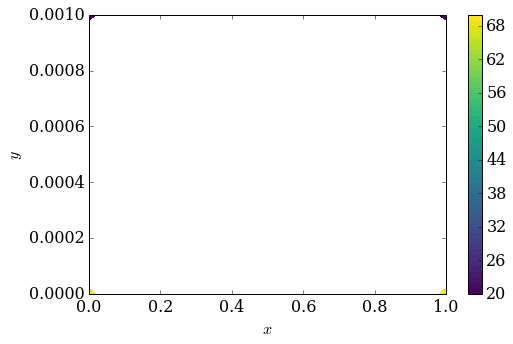

In [148]:
plt.figure(figsize=(8,5))
plt.contourf(x,y,T,50,cmap=cm.viridis)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar();


In [146]:
print(T)

[[ 70.  70.  70. ...,  70.  70.  70.]
 [ 69.  nan  nan ...,  nan  nan  69.]
 [ 68.  nan  nan ...,  nan  nan  68.]
 ..., 
 [ 22.  nan  nan ...,  nan  nan  22.]
 [ 21.  nan  nan ...,  nan  nan  21.]
 [ 20.  20.  20. ...,  20.  20.  20.]]


In [147]:
print(ui)

NameError: name 'ui' is not defined

In [ ]:
print(pi)